Imports

In [1]:
# System utilities
import os
from pathlib import Path
import datetime
import json
import random

# Reddit API
import praw
from praw.models import MoreComments
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Open AI API
import openai

# Pandas
import pandas as pd

# Models
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

/Users/jb/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data Collection

In [2]:
enableDataCollect = False

In [3]:
with open('secrets.json', 'r') as f:
    data = f.read()

secrets = json.loads(data)

client_id = secrets['client_id']
client_secret = secrets['client_secret']
pw = secrets['password']
user_agent = secrets['user_agent']
user_name = secrets['username']

In [4]:
reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    password=pw,
    user_agent=user_agent,
    username=user_name,
)

In [5]:
def get_post_time(submission):
        time = submission.created
        return datetime.datetime.fromtimestamp(time)

In [6]:
def collect_post_info(subreddit, post_limit, time_filter, output_loc):
    count = 0
    
    for submission in reddit.subreddit(subreddit).top(time_filter=time_filter, limit=post_limit):
        if (submission.num_comments > 50):   
            submissionList.append(submission.title)
            
            meta_col_list = ['id', 'title', 'time', 'upvotes', 'num_comments', 'assessment']
            comment_col_list = ['id', 'text', 'time', 'upvotes', 'length', 'assessment']
            
            meta_df = pd.DataFrame(columns=meta_col_list)
            meta_df.loc[0] = [count, submission.title, get_post_time(submission), submission.score, submission.num_comments, 0]
            
            comment_df = pd.DataFrame(columns=comment_col_list)
            
            post_meta_file = str(count) + "_" + submission.title[:10]
            
            output_path = output_loc + "/" + post_meta_file
            
            Path(output_path).mkdir(parents=True, exist_ok=True)
            
            output_file = output_path + "/" + post_meta_file
            
            meta_df.to_csv(output_file, index=False)
            
            comment_count = 0
            for top_level_comment in submission.comments:
                if isinstance(top_level_comment, MoreComments):
                    continue
                    
                comment_row = pd.Series({'id': comment_count, 'text': top_level_comment.body, 
                                         'time': get_post_time(top_level_comment), 'upvotes': top_level_comment.score,
                                         'length': 0, 'assessment': 0})
                
                comment_df = pd.concat([comment_df, comment_row.to_frame().T], ignore_index=True)
                                                
                comment_count = comment_count + 1
                            
            comment_output = output_path + "/" + post_meta_file + "_comments"
            comment_df.to_csv(comment_output, index=False)
            
            comment_df
        count = count + 1

In [7]:
subreddit_targets = ['sports', 'news', 'askreddit', 'movies', 'funny']

In [8]:
if (enableDataCollect):
    root_path = "subreddit"

    Path(root_path).mkdir(parents=True, exist_ok=True)

    for subreddit in subreddit_targets:
        dir_path = root_path + "/" + subreddit 
        Path(dir_path).mkdir(parents=True, exist_ok=True)

        collect_post_info(subreddit, 10, "all", dir_path)
else:
    print("Skipping data collection")

Skipping data collection


Load Open AI

In [9]:
with open('secrets.json', 'r') as f:
    data = f.read()

secrets = json.loads(data)

openai_key = secrets['openai_key']

In [10]:
openai.api_key = openai_key

Load Aspect Based Sentiment Analysis Model

huggingface.co/yangheng/deberta-v3-base-absa-v1.1

In [12]:
absa_tokenizer = AutoTokenizer.from_pretrained("yangheng/deberta-v3-base-absa-v1.1", use_fast=False)
absa_model = AutoModelForSequenceClassification.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")

Utility Functions

In [13]:
def getResponseText(response):
    return response.choices[0].text.strip()

In [14]:
def response_request(prompt_starter, title):
    response = openai.Completion.create(
        model="text-davinci-002",
        prompt=prompt_starter + title,
        temperature=0,
        max_tokens=100,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )
    
    return response

In [15]:
def get_all_comment_text(input_df):
    all_text = ""

    for index, row in input_df.iterrows():
        all_text = all_text + row['text'] + ","
        
    return all_text

In [16]:
def prompt_gen(keyword):
    prompt_starter = "Make a short and " + keyword + " reply about:"
    return prompt_starter

In [17]:
def get_sentiment_values(comment, aspect_keywords, sentiment_df_temp):
    row_text = comment
    gen_comment_row_values = [row_text]
    prob_dict = {}
    for aspect in aspect_keywords:
        inputs = absa_tokenizer(f"[CLS] {comment} [SEP] {aspect} [SEP]", return_tensors="pt")
        outputs = absa_model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)
        probs = probs.detach().numpy()[0]

        for prob, label in zip(probs, ['neg', 'neu', 'pos']):                        
            prob_type = aspect + "_" + label
            print(f'Label {prob_type}: {prob}')
            prob_dict.update({prob_type: prob})  
            
    for x in prob_dict:
        gen_comment_row_values.append(prob_dict[x])        
        
    sentiment_df_temp.loc[len(sentiment_df_temp.index)] = gen_comment_row_values 
    
    return sentiment_df_temp

Main

Starting with loading the Data Set
- For this example, the data set is one of the random top posts selected from the 'sports' subreddit


In [48]:
root_dir = "subreddit/sports/"

ran_post = random.choice(os.listdir(root_dir))

post_df = pd.read_csv(root_dir + ran_post + "/" + ran_post)
comments_df = pd.read_csv(root_dir + ran_post + "/" + ran_post + "_comments")

In [49]:
print("Post Metadata")

print(f"ID: {str(post_df.iloc[0]['id'])}")
print(f"Title: {post_df.iloc[0]['title']}")
print(f"Score: {post_df.iloc[0]['upvotes']}")
print(f"Time Posted: {post_df.iloc[0]['time']}")
print(f"Number of Comments: {post_df.iloc[0]['num_comments']}")

Post Metadata
ID: 240
Title: Suns center Bismack Biyombo is donating the entirety of his $1.3 million salary for this season, to fund the construction of a hospital in the Democratic Republic of the Congo
Score: 52834
Time Posted: 2022-04-07 06:41:02
Number of Comments: 922


Using open AI without any modifcations

In [50]:
post_title = post_df.iloc[0]['title']

response = openai.Completion.create(
  model="text-davinci-002",
  prompt="Make a comment about: " + post_title,
  temperature=0,
  max_tokens=100,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0
)

getResponseText(response)

'This is an amazing act of charity by Bismack Biyombo. By donating his entire salary for this season, he will help fund the construction of a hospital in the Democratic Republic of the Congo. This will undoubtedly save many lives and improve the quality of life for countless people in the Congo.'

By itself, the openai model is able to produce a reasonable response to the question with no context beyond the post of the title. The response is a bit robotic, however, and it does not seem like something someone would post. Reformatting the prompt based on the other comments could benefit with making the prompt more realistic

In [51]:
response = openai.Completion.create(
  model="text-davinci-002",
  prompt="Make a basic first person comment about: " + post_title,
  temperature=0,
  max_tokens=100,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0
)

getResponseText(response)

'"Suns center Bismack Biyombo is donating the entirety of his $1.3 million salary for this season, to fund the construction of a hospital in the Democratic Republic of the Congo. That\'s amazing! He\'s really making a difference in the world."'

Better, but still not a 'reddit' looking comment

In [52]:
comments_df.head()

,id,text,time,upvotes,length,assessment
0,0,[**Join Our Discord Server!**](https://discord...,2022-04-07 07:33:02,1,0,0
1,1,Righteous men lift up others. Let’s go,2022-04-07 07:51:57,3171,0,0
2,2,Respect!,2022-04-07 07:27:39,921,0,0
3,3,He gave us Raptors fans lots to cheer for when...,2022-04-07 08:20:19,641,0,0
4,4,Is there a better name for a center in the his...,2022-04-07 09:14:44,69,0,0


Aspect Based Sentiment Analysis

In [53]:
aspect_keywords = [
    'joking', 
    'excited',
    'depressing',
    'sarcastic',
    'frustrating',
    'annoying',
    'joyful'
]

In [54]:
columns_list = ['text']

for keyword in aspect_keywords:
    columns_list.append(keyword + "_neg")
    columns_list.append(keyword + "_neu")
    columns_list.append(keyword + "_pos")

comment_sentiment_df = pd.DataFrame(columns=columns_list)
gen_comment_sentiment_df = pd.DataFrame(columns=columns_list)

In [55]:
for index, row in comments_df.iterrows():
    row_text = row['text']
    comment_row_values = [row_text]
    prob_dict = {}

    for aspect in aspect_keywords:
        inputs = absa_tokenizer(f"[CLS] {row['text']} [SEP] {aspect} [SEP]", return_tensors="pt")
        outputs = absa_model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)
        probs = probs.detach().numpy()[0]

        for prob, label in zip(probs, ['neg', 'neu', 'pos']):
            prob_type = aspect + "_" + label
            prob_dict.update({prob_type: prob})
            
    for x in prob_dict:
        comment_row_values.append(prob_dict[x])        
        
    comment_sentiment_df.loc[len(comment_sentiment_df.index)] = comment_row_values
    

In [56]:
comment_sentiment_df.head()

,text,joking_neg,joking_neu,joking_pos,excited_neg,excited_neu,excited_pos,depressing_neg,depressing_neu,depressing_pos,...,sarcastic_pos,frustrating_neg,frustrating_neu,frustrating_pos,annoying_neg,annoying_neu,annoying_pos,joyful_neg,joyful_neu,joyful_pos
0,[**Join Our Discord Server!**](https://discord...,0.005891,0.281654,0.712456,0.003729,0.140673,0.855598,0.020873,0.377524,0.601603,...,0.618545,0.026091,0.305376,0.668533,0.024124,0.271976,0.703900,0.003701,0.142863,0.853436
1,Righteous men lift up others. Let’s go,0.095762,0.551613,0.352625,0.015565,0.598750,0.385685,0.783246,0.133168,0.083586,...,0.082659,0.768398,0.110655,0.120947,0.683202,0.213282,0.103516,0.012229,0.311493,0.676279
2,Respect!,0.639649,0.276650,0.083701,0.012782,0.128441,0.858776,0.942629,0.048862,0.008509,...,0.012318,0.983576,0.014221,0.002203,0.986965,0.010728,0.002306,0.011857,0.190070,0.798073
3,He gave us Raptors fans lots to cheer for when...,0.017280,0.073487,0.909233,0.006620,0.047867,0.945514,0.248915,0.063809,0.687276,...,0.849271,0.201285,0.067002,0.731713,0.217268,0.079584,0.703148,0.005747,0.031516,0.962737
4,Is there a better name for a center in the his...,0.274907,0.194266,0.530827,0.015186,0.261299,0.723515,0.835062,0.139984,0.024954,...,0.110084,0.846466,0.135524,0.018010,0.929524,0.060339,0.010136,0.013693,0.187314,0.798993


In [57]:
comment_sentiment_df.mean()

/var/folders/8x/96fv9lvs3ts4pvsg8w_06j4r0000gn/T/ipykernel_87155/2458701697.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  comment_sentiment_df.mean()


joking_neg         0.342384
joking_neu         0.244332
joking_pos         0.413283
excited_neg        0.117800
excited_neu        0.244651
excited_pos        0.637548
depressing_neg     0.716802
depressing_neu     0.107442
depressing_pos     0.175756
sarcastic_neg      0.431786
sarcastic_neu      0.310909
sarcastic_pos      0.257305
frustrating_neg    0.754063
frustrating_neu    0.089738
frustrating_pos    0.156199
annoying_neg       0.777193
annoying_neu       0.084720
annoying_pos       0.138087
joyful_neg         0.109033
joyful_neu         0.190000
joyful_pos         0.700967
dtype: float32

Based on this aspect based sentiment analysis, the joyful and excited aspects were the most postive.

In [58]:
response = response_request(prompt_gen('joking'), post_df.iloc[0]['title'])
response2 = response_request(prompt_gen('excited'), post_df.iloc[0]['title'])

In [59]:
formatted_response = getResponseText(response)
formatted_response

'"Wow, what a guy! I bet he\'s really popular with the ladies now."'

In [60]:
formatted_response2 = getResponseText(response2)
formatted_response2

'This is amazing news! Bismack Biyombo is an incredible human being.'

In [32]:
return_df = get_sentiment_values(formatted_response, aspect_keywords, gen_comment_sentiment_df)

Label joking_neg: 0.02469404600560665
Label joking_neu: 0.3453378677368164
Label joking_pos: 0.6299680471420288
Label excited_neg: 0.007943980395793915
Label excited_neu: 0.30738797783851624
Label excited_pos: 0.6846680641174316
Label depressing_neg: 0.2925586700439453
Label depressing_neu: 0.45012813806533813
Label depressing_pos: 0.25731325149536133
Label sarcastic_neg: 0.06050918996334076
Label sarcastic_neu: 0.6702908873558044
Label sarcastic_pos: 0.269199937582016
Label frustrating_neg: 0.6284207701683044
Label frustrating_neu: 0.289056658744812
Label frustrating_pos: 0.08252254128456116
Label annoying_neg: 0.6579211354255676
Label annoying_neu: 0.1946270912885666
Label annoying_pos: 0.14745169878005981
Label joyful_neg: 0.004180455580353737
Label joyful_neu: 0.09523093700408936
Label joyful_pos: 0.9005885720252991


In [33]:
return_df2 = get_sentiment_values(formatted_response2, aspect_keywords, gen_comment_sentiment_df)

Label joking_neg: 0.011812146753072739
Label joking_neu: 0.03811014071106911
Label joking_pos: 0.9500777721405029
Label excited_neg: 0.0014787166146561503
Label excited_neu: 0.015639524906873703
Label excited_pos: 0.9828817844390869
Label depressing_neg: 0.41082707047462463
Label depressing_neu: 0.255340576171875
Label depressing_pos: 0.33383238315582275
Label sarcastic_neg: 0.07820019870996475
Label sarcastic_neu: 0.24669212102890015
Label sarcastic_pos: 0.6751077175140381
Label frustrating_neg: 0.7174177169799805
Label frustrating_neu: 0.11704625189304352
Label frustrating_pos: 0.1655360460281372
Label annoying_neg: 0.5982942581176758
Label annoying_neu: 0.16031400859355927
Label annoying_pos: 0.24139171838760376
Label joyful_neg: 0.001419078791514039
Label joyful_neu: 0.013639269396662712
Label joyful_pos: 0.9849416017532349


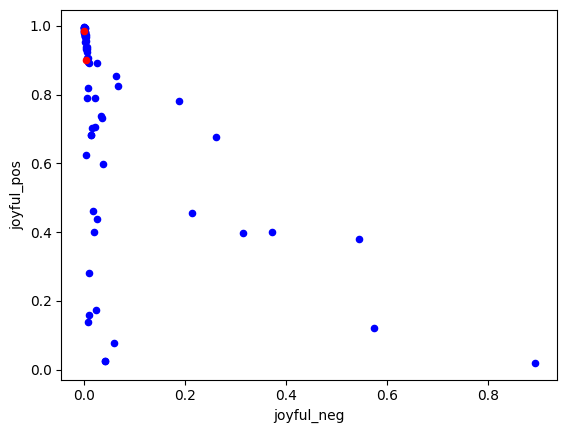

In [34]:
ax1 = comment_sentiment_df.plot.scatter(x='joyful_neg', y='joyful_pos', c='blue')
ax2 = return_df2.plot.scatter(x='joyful_neg', y='joyful_pos', c='red', ax=ax1)

In [260]:
responses = []

for aspect in aspect_keywords:
    response = response_request(prompt_gen(aspect), post_df.iloc[0]['title'])
    responses.append(getResponseText(response))

In [261]:
responses

['"Wow, those Hopkins lacrosse players are really sneaky! I bet the Navy players feel pretty foolish right about now."',
 "Wow! That's amazing!",
 'This is the world we live in.',
 '"Wow, those Hopkins lacrosse players are really smart! I\'m sure the Navy players feel really stupid now."',
 'This is the most frustrating thing ever.',
 'This is the most exciting thing to happen in lacrosse in years!',
 "That's amazing! Hopkins is my favorite team!"]

In [262]:
top_ten_df = comments_df.sort_values(by=['upvotes'], ascending=False).head(10)
bottom_ten_df = comments_df.sort_values(by=['upvotes']).head(10)

In [263]:
for index, row in top_ten_df.iterrows():
    print(row['text'])

It's the opposing goalkeeper, frozen like a statue and oblivious that really does it for me.
didn't fool the camera man luckily!
[deleted]
I don’t know much about lacrosse so whenever I watch it the ball’s hidden from me 80% of the game 
What’s even more amazing is that one guy, Johns, is beating the entire Navy team 8-7
I like how the mannequin standing in the goal was dressed. 
Ref on that sharingan 
Still not an easy shot. 
Damn I haven't seen Navy caught that off guard since Pearl Harbor
If anyone is interested in learning more about this sport, the NCAA DI Championship game will be televised tomorrow on ESPN2 at 1:00** ET.

We apologize in advance for the announcer known as Quint.

EDIT: sorry, 1 pm


In [264]:
for index, row in bottom_ten_df.iterrows():
    print(row['text'])

Navy #44 is still covering the Hopkins player #55. This is just a good shot.
Lacrosse is the worst.
Good job Conner
Got eeeeem
I have never seen this before wow !
Wait when was this game? I don't remember seeing it
Gotta love the old school tricks
"Hey, did they just score?"

"I think you might be right..."
The goalee didn’t even flinch as the ball flew right past him lmao 
If this happened to a team I was on, my head would explode.


In [343]:
root_dir = "subreddit/sports/"

ran_post = random.choice(os.listdir(root_dir))

post_df = pd.read_csv(root_dir + ran_post + "/" + ran_post)
comments_df = pd.read_csv(root_dir + ran_post + "/" + ran_post + "_comments")

In [344]:
print("Post Metadata")

print(f"ID: {str(post_df.iloc[0]['id'])}")
print(f"Title: {post_df.iloc[0]['title']}")
print(f"Score: {post_df.iloc[0]['upvotes']}")
print(f"Time Posted: {post_df.iloc[0]['time']}")
print(f"Number of Comments: {post_df.iloc[0]['num_comments']}")

Post Metadata
ID: 116
Title: Irvin Cardona spectacular mid-air volley during french Ligue 1
Score: 64143
Time Posted: 2020-09-14 01:00:08
Number of Comments: 1059


In [345]:
post_title = post_df.iloc[0]['title']

response = openai.Completion.create(
  model="text-davinci-002",
  prompt="Make a joking comment about: " + post_title,
  temperature=0,
  max_tokens=100,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0
)

getResponseText(response)

'match\n\n"He must have been watching a lot of FIFA lately!"'

In [346]:
top_ten_df = comments_df.sort_values(by=['upvotes'], ascending=False).head(10)
bottom_ten_df = comments_df.sort_values(by=['upvotes']).head(10)

In [347]:
top_ten_df

,id,text,time,upvotes,length,assessment
2,2,That is one of the most spectacular sports hig...,2020-09-14 02:01:52,5039,0,0
3,3,This is what manga-type soccer would look like...,2020-09-14 01:27:12,3640,0,0
4,4,This guy must have loved the movie shaolin soccer,2020-09-14 02:18:41,1281,0,0
5,5,GOTY material,2020-09-14 02:01:27,685,0,0
8,8,Thing I always find most impressive in goals l...,2020-09-14 02:58:43,626,0,0
1,1,This is what all the other pro footballers ima...,2020-09-14 03:52:33,292,0,0
6,6,"I played soccer for 20 years, noone told me fl...",2020-09-14 03:36:28,256,0,0
9,9,"And to think, immediately following this goal,...",2020-09-14 04:29:55,206,0,0
7,7,[deleted],2020-09-14 02:34:29,153,0,0
12,12,wow the level of athleticism!,2020-09-14 02:17:37,44,0,0


In [348]:
bottom_ten_df

,id,text,time,upvotes,length,assessment
0,0,[**Join Our Discord Server!**](https://discord...,2020-09-14 01:05:04,1,0,0
136,136,Kung Fu kick haven't seen that in a while,2020-09-14 06:51:42,1,0,0
137,137,Galactik football type of shit,2020-09-14 06:52:58,1,0,0
138,138,This is like in sports games when it slows dow...,2020-09-14 06:53:50,1,0,0
139,139,"The karate kid , French ligue version",2020-09-14 06:54:49,1,0,0
140,140,This is the Air Jordan of soccer,2020-09-14 06:55:23,1,0,0
141,141,u/vredditdownload,2020-09-14 06:56:27,1,0,0
142,142,Unreal athleticism,2020-09-14 06:57:55,1,0,0
143,143,u/vredditdownloader,2020-09-14 06:59:40,1,0,0
144,144,"Very shaolin socceresqe, great goal!",2020-09-14 07:02:03,1,0,0


In [349]:
columns_list = ['text']

for keyword in aspect_keywords:
    columns_list.append(keyword + "_neg")
    columns_list.append(keyword + "_neu")
    columns_list.append(keyword + "_pos")

comment_sentiment_df = pd.DataFrame(columns=columns_list)
gen_comment_sentiment_df = pd.DataFrame(columns=columns_list)

In [ ]:
for index, row in comments_df.iterrows():
    row_text = row['text']
    comment_row_values = [row_text]
    prob_dict = {}

    for aspect in aspect_keywords:
        inputs = absa_tokenizer(f"[CLS] {row['text']} [SEP] {aspect} [SEP]", return_tensors="pt")
        outputs = absa_model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)
        probs = probs.detach().numpy()[0]

        for prob, label in zip(probs, ['neg', 'neu', 'pos']):
            prob_type = aspect + "_" + label
            prob_dict.update({prob_type: prob})
            
    for x in prob_dict:
        comment_row_values.append(prob_dict[x])        
        
    comment_sentiment_df.loc[len(comment_sentiment_df.index)] = comment_row_values
    

In [ ]:
comment_sentiment_df.mean()